# NLP Dataset - IMDB-50K Movie Review Analysis

## Assignment Details

**Problem Statement:** 1 (IMDB-50K Movie Review Analysis)<br>
**Question:** No.2. NLP Dataset<br>
**Group:** DL Assignment Groups 21<br>
**Group Members:**
* Harish Pasupuleti - 2019AP04028
* Sanket Walke - 2019AP04052
* Chitral Verma - 2019AP04012

### This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

### Mounting Google drive to load source data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries/dataset

### a.	Import the required libraries and the dataset 

In [ ]:
import pandas as pd
import numpy as np
import itertools
import time
import nltk
import re
from wordcloud import WordCloud
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import Adam
from keras import regularizers
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


###Load and Check Data

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [ ]:
# Size of our data.
data.shape

(50000, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# statistical summary of our data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


### b. Check GPU availability

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
print("GPU device name:", tf.test.gpu_device_name())

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available
GPU device name: /device:GPU:0


## 2.	Data Visualization and augmentation 

In [ ]:
#browsing the data
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### a.	Print at least two movie reviews from each class

In [ ]:
data[data['sentiment']=='positive'].head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [ ]:
data[data['sentiment']=='negative'].head(2)

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative


### b.	Plot a bar graph of class distribution 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


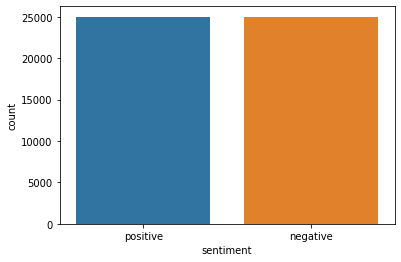

negative    25000
positive    25000
Name: sentiment, dtype: int64


In [ ]:
sns.countplot(data['sentiment'])
plt.show()
print(data.sentiment.value_counts())

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We see that the number of positive and negative comments is equal. </p> </li>
</ul>

In [ ]:
data.sentiment=[1 if sentiment=='positive' else 0 for sentiment in data.sentiment]

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > We convert our sentiment property to int values. </p> </li>
        <li  style = "color:green" > <p style = "color:black;font-weight:bold" > positive --> 1 </p> </li>
        <li  style = "color:red" > <p style = "color:black;font-weight:bold" > negative --> 0 </p> </li>
</ul>

In [ ]:
print(data.sentiment.value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


<a id ='2' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0">Ineffective Words </h2>

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > Let's first take a look at the ineffective English words. </p> </li>
</ul>

In [ ]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [ ]:
WPT= nltk.WordPunctTokenizer()
stop_words_list=nltk.corpus.stopwords.words('english')

In [ ]:
print(stop_words_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<a id ='3' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0">Clearing data </h2>

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > process of clearing punctuation marks in data. </p> </li>
     <li  style = "color:green" > <p style = "color:black;font-weight:bold" > cleaning unnecessary marks in data. </p> </li>
        <li  style = "color:red" > <p style = "color:black;font-weight:bold" > capitalization to lowercase. </p> </li>
     <li  style = "color:green" > <p style = "color:black;font-weight:bold" > cleaning extra spaces. </p> </li>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > removal of stopwords in sentences. </p> </li>
</ul>

In [ ]:
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

data['review'] = data['review'].apply(lambda x: x.lower())

data['review'] = data['review'].apply(lambda x: x.strip())

In [ ]:
data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the ...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1
5,probably my all time favorite movie a story of...,1
6,i sure would like to see a resurrection of a u...,1
7,this show was an amazing fresh innovative id...,0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


In [ ]:
"""
I closed the stopword process because it took a long time.
If you want, you can try opening the codes in the comment line.
"""
# def token(values):
#    words = nltk.tokenize.word_tokenize(values)
#    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
#    not_stopword_doc = " ".join(filtered_words)
#    return not_stopword_doc
# data['review'] = data['review'].apply(lambda x: token(x))

'\nI closed the stopword process because it took a long time.\nIf you want, you can try opening the codes in the comment line.\n'

### c. Other Visualizations 

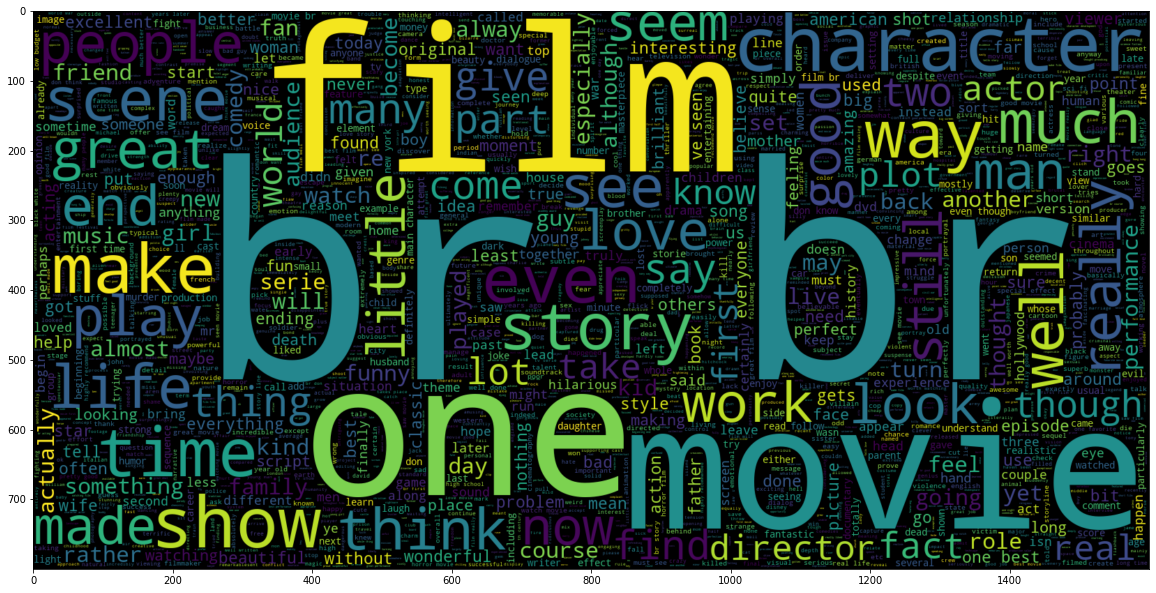

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

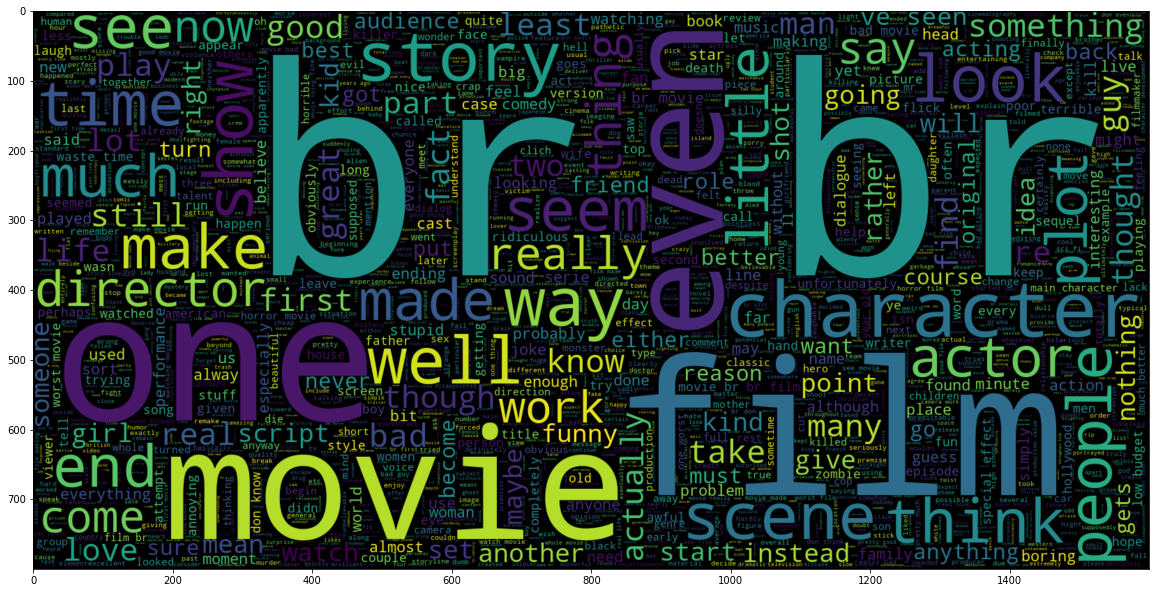

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

<a id ='4' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Train - Test Split </h2>

In [ ]:
sentiment=data.sentiment.values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
data=data['review']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(data,sentiment,test_size=0.2)

### d. Shapes of train and test data

In [ ]:
print('X Train size:',x_train.shape)
print('X Test size:', x_test.shape)

Train set size: (40000,)
Test set size: (10000,)


## 3.	Data Pre-processing 

### a. Handling string data

<a id ='5' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Creating a Dictionary </h2>

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We create a dictionary of 15000 most used words in English for later use. </p> </li>
</ul>

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
tokenizer= Tokenizer(num_words=15000)
tokenizer.fit_on_texts(data)

In [ ]:
print(tokenizer.word_index)

Output hidden; open in https://colab.research.google.com to view.

<a id ='6' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Bring the comments to the same size </h2>

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > comments of different lengths cannot train the model. That's why we need to make the sentences the same size. </p> </li>
</ul>

In [ ]:
x_train_token= tokenizer.texts_to_sequences(x_train)
x_test_token= tokenizer.texts_to_sequences(x_test)

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" >We replace the words in our sentences with whichever index they are included in the dictionary we have created above. </p> </li>
</ul>

In [ ]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens=[len(num) for num in x_train_token+x_test_token]
num_tokens=np.array(num_tokens)

In [ ]:
num_tokens

array([130, 400, 241, ..., 117, 114, 130])

In [ ]:
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

567

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average. </p> </li>
</ul>

In [ ]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens<max_tokens)/len(num_tokens)

0.94524

### b. Using a pre training embedded layer from Tensorflow hub.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

### c.	Bring the train and test data in the required format.

In [ ]:
#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_token, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_token, maxlen=max_tokens)

In [ ]:
x_train_pad.shape
x_test_pad.shape

(10000, 567)

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > As you can see, we have set it to shape 567. So max_tokens
 </p> </li>
</ul>

In [ ]:
idx=tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
print(inverse_map)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def return_to_sentence(tokens):
  words= [inverse_map[token] for token in tokens if token!=0]
  text=' '.join(words)
  return text

<ul>
    <li  style = "color:red" > <p style = "color:black;font-weight:bold" > We write a function to revert the sentences that we have made int.
 </p> </li>
</ul>

In [ ]:
#normal comment
print(return_to_sentence(x_train_pad[215]))

spoilers simple movie about simple people who s problems are far too complex for them to handle br br natalie aka sara shirley knight has become overwhelmed with married life and the fact that she s now pregnant is the straw that breaks the s back taking off from her homes in long island new york natalie has no idea where she s going but hopes to find peace and somewhere in the of america it s on the pennsylvania that natalie picks up hitchhiker jimmie killer james seems as lost and confused as she is as natalie calling herself sara at the time soon finds out jimmie had suffered a serious brain while playing football on his collage team and has been reduced to such a simple minded individual who s so passive that he lets everyone including later in the movie natalie step all over him br br sympathetic at first natalie becomes very annoyed at the self jimmie for not standing up for himself and letting himself be used as a by everyone he comes in contact with in the movie not knowing wha

In [ ]:
#token equivalent of comment
print(x_train_pad[215])

[    0     0     0     0     0     0     0     0     0     0     0  1017
   584    17    44   584    80    36    13   683    26   224    98  1279
    16    93     5  2779     7     7  4872  2178  5487  4180  4221    47
   422  8786    18  1042   114     2     1   192    12    55    13   149
  2761     6     1  8922    12  2038     1    13   145   634   123    38
    43  6029     9   195   909   169   834  4872    47    57   320   116
    55    13   168    19  1942     5   167  2387     2  1191     9     1
     4   829     8    13    22     1 14685    12  4872  2937    56  9795
 14934   472   595   186    15   423     2  1437    15    55     6    15
  4872  2378   796  5487    31     1    58   521   678    45 14934    68
  3141     3   588  1091   137   392  2031    22    27 11403   699     2
    47    76  4031     5   141     3   584  2783  2075    36    13    37
  8519    12    25  1548   293   583   306     9     1    17  4872  1522
    32   122    89     7     7  2165    31    87  4

## Model Building

  #### a.	Sequential Model layers- Use AT LEAST 3 hidden     layers with appropriate input for each. Choose the best number for hidden units and give reasons.

  #### b.	Add L2 regularization to all the layers.

  #### c.	Add one layer of dropout at the appropriate position and give reasons.

### d.	Choose the appropriate activation function for all the layers

In [ ]:

model = tf.keras.Sequential()
model.add(hub_layer)

model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


model.add(tf.keras.layers.Dense(1))



### e.	Print the model summary.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 124,644,929
Trainable params: 124,644,929
Non-trainable params: 0
________________________________________

## 5. Model Compilation

### a.	Compile the model with the appropriate loss function.

### b.	Use an appropriate optimizer.

### c.	Use accuracy as a metric.

In [ ]:
# ----- Compile model -----

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])


## 6.	Model Training 

#### a.	Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

In [ ]:
start = time.time()

In [ ]:
history=model.fit(x_train,y_train,validation_split=0.3, epochs=10, batch_size=1000, shuffle=True, verbose=1)

Epoch 1/10
28/28 [==============================] - 4s 135ms/step - loss: 6.4205 - accuracy: 0.4998 - val_loss: 2.4134 - val_accuracy: 0.5077
Epoch 2/10
28/28 [==============================] - 4s 127ms/step - loss: 2.9729 - accuracy: 0.4994 - val_loss: 1.8787 - val_accuracy: 0.5077
Epoch 3/10
28/28 [==============================] - 4s 127ms/step - loss: 2.4827 - accuracy: 0.5020 - val_loss: 1.7543 - val_accuracy: 0.5077
Epoch 4/10
28/28 [==============================] - 4s 126ms/step - loss: 2.2646 - accuracy: 0.5023 - val_loss: 1.6861 - val_accuracy: 0.5077
Epoch 5/10
28/28 [==============================] - 4s 127ms/step - loss: 1.9917 - accuracy: 0.5020 - val_loss: 1.6372 - val_accuracy: 0.5077
Epoch 6/10
28/28 [==============================] - 4s 127ms/step - loss: 1.8572 - accuracy: 0.5010 - val_loss: 1.5964 - val_accuracy: 0.5077
Epoch 7/10
28/28 [==============================] - 4s 126ms/step - loss: 1.7821 - accuracy: 0.4946 - val_loss: 1.5561 - val_accuracy: 0.5077
Epoch 

#### b.	Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
# Print the total time taken for training
print("Total time taken for training: ", time.time() - start, "seconds")

Total time taken for training:  36.28858017921448 seconds


<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

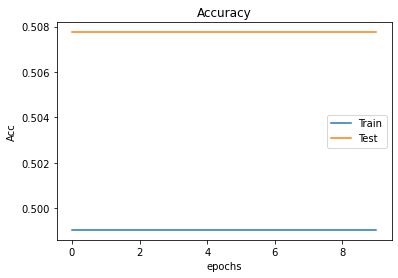

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

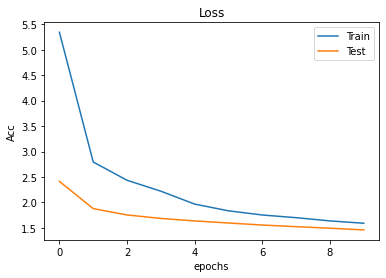

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Model Evaluation

#### a.i)	Print the final train and validation loss and accuracy

In [ ]:
testLoss, testAccuracy = model.evaluate(x_test,y_test)

# Print the final test/validation loss and accuracy.
print('Final testing loss \t', testLoss)
print('Final testing accuracy ', testAccuracy)

313/313 [==============================] - 1s 4ms/step - loss: 1.4872 - accuracy: 0.4934
Final testing loss 	 1.4872289896011353
Final testing accuracy  0.4934000074863434


#### a.ii) Plot Confusion Matrix

In [ ]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
y_test_1d=["POSITIVE" if sentiment==1 else "NEGATIVE" for sentiment in y_test]
y_pred_1d = []
y_test_1d = list(y_test_1d)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 0s 84ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

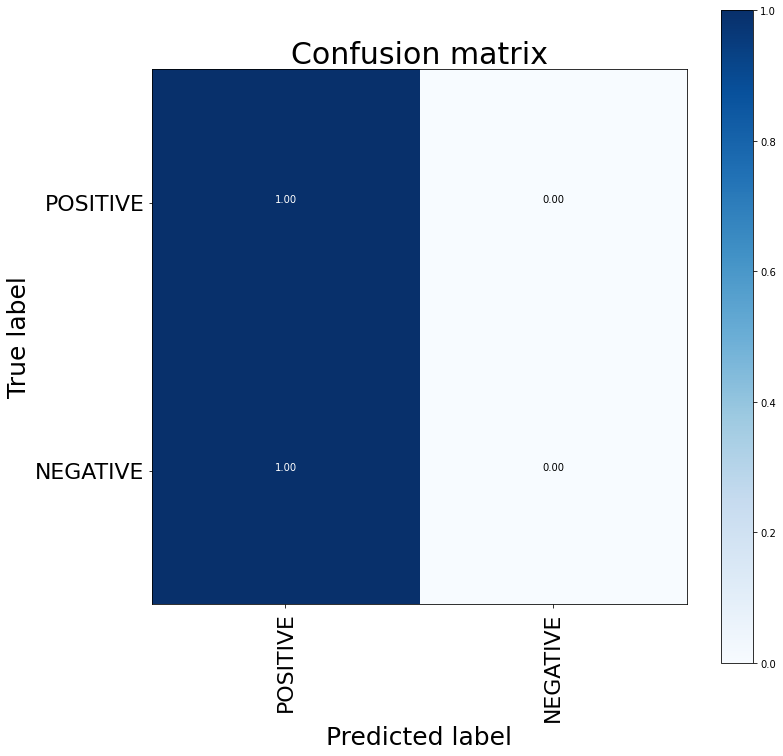

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=['POSITIVE','NEGATIVE'], title="Confusion matrix")
plt.show()

#### a.iii) Print Classification report

In [ ]:
probabilities = model.predict(x_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.4934
 
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      4934
           1       0.00      0.00      0.00      5066

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### a.iv). Write a summary for the best and worst performing class and the overall trend

**NEGATIVE** is the **best** performing class with 67% F1-Score and **POSITIVE** is **worst** performing class with 0% F1-Score.

#### b.	Print the two most incorrectly classified texts for each class in the test dataset.

In [ ]:
# show actual and predicted class labels - Overall trend

for i in range(20):
    print ("Actual= {}  Predicted = {}".format(y_test[i], pred[i]))

Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0


# Version 2 of the model with different hyperparameters

## Model Building

  #### a.	Sequential Model layers- Use AT LEAST 3 hidden     layers with appropriate input for each. Choose the best number for hidden units and give reasons.

  #### b.	Add L2 regularization to all the layers.

  #### c.	Add one layer of dropout at the appropriate position and give reasons.

### d.	Choose the appropriate activation function for all the layers

In [ ]:

model = tf.keras.Sequential()
model.add(hub_layer)

model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


model.add(tf.keras.layers.Dense(1))



### e.	Print the model summary.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 124,644,929
Trainable params: 124,644,929
Non-trainable params: 0
________________________________________

## 5. Model Compilation

### a.	Compile the model with the appropriate loss function.

### b.	Use an appropriate optimizer.

### c.	Use accuracy as a metric.

In [ ]:
# ----- Compile model -----

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])



## 6.	Model Training 

#### a.	Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

In [ ]:
start = time.time()

In [ ]:
history=model.fit(x_train,y_train,validation_split=0.3, epochs=10, batch_size=500, shuffle=True, verbose=1)

Epoch 1/15
56/56 [==============================] - 6s 102ms/step - loss: 8.1632 - accuracy: 0.4994 - val_loss: 8.0139 - val_accuracy: 0.5077
Epoch 2/15
56/56 [==============================] - 6s 100ms/step - loss: 8.1378 - accuracy: 0.4993 - val_loss: 7.9881 - val_accuracy: 0.5077
Epoch 3/15
56/56 [==============================] - 5s 98ms/step - loss: 8.1976 - accuracy: 0.4938 - val_loss: 7.9640 - val_accuracy: 0.5077
Epoch 4/15
56/56 [==============================] - 5s 98ms/step - loss: 8.1751 - accuracy: 0.4937 - val_loss: 7.9415 - val_accuracy: 0.5077
Epoch 5/15
56/56 [==============================] - 5s 98ms/step - loss: 8.0522 - accuracy: 0.5002 - val_loss: 7.9204 - val_accuracy: 0.5077
Epoch 6/15
56/56 [==============================] - 6s 99ms/step - loss: 7.9888 - accuracy: 0.5030 - val_loss: 7.9008 - val_accuracy: 0.5077
Epoch 7/15
56/56 [==============================] - 5s 98ms/step - loss: 8.0383 - accuracy: 0.4985 - val_loss: 7.8824 - val_accuracy: 0.5077
Epoch 8/15


#### b.	Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
# Print the total time taken for training
print("Total time taken for training: ", time.time() - start, "seconds")

Total time taken for training:  83.63303875923157 seconds


<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

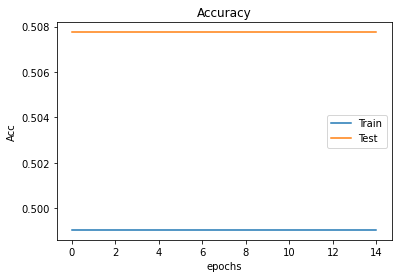

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

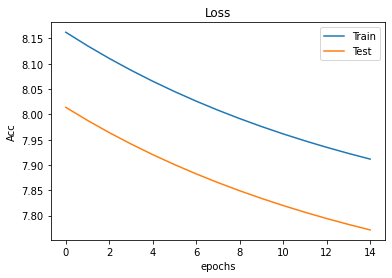

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Model Evaluation

#### a.i)	Print the final train and validation loss and accuracy

In [ ]:
testLoss, testAccuracy = model.evaluate(x_test,y_test)

# Print the final test/validation loss and accuracy.
print('Final testing loss \t', testLoss)
print('Final testing accuracy ', testAccuracy)

313/313 [==============================] - 1s 4ms/step - loss: 7.9931 - accuracy: 0.4934
Final testing loss 	 7.993066310882568
Final testing accuracy  0.4934000074863434


#### a.ii) Plot Confusion Matrix

In [ ]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
y_test_1d=["POSITIVE" if sentiment==1 else "NEGATIVE" for sentiment in y_test]
y_pred_1d = []
y_test_1d = list(y_test_1d)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 0s 84ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

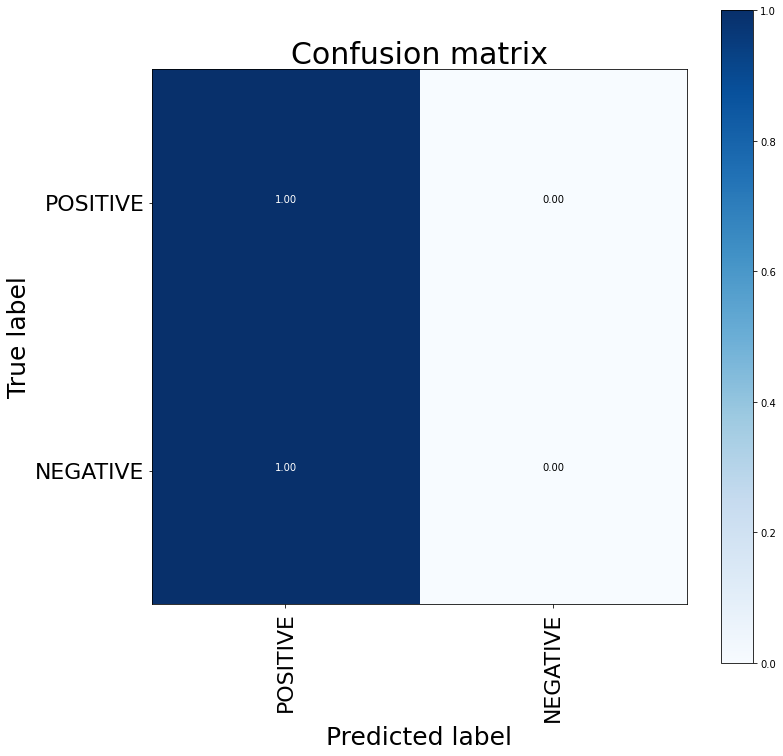

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=['POSITIVE','NEGATIVE'], title="Confusion matrix")
plt.show()

#### a.iii) Print Classification report

In [ ]:
probabilities = model.predict(x_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.4934
 
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      4934
           1       0.00      0.00      0.00      5066

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### a.iv). Write a summary for the best and worst performing class and the overall trend

**NEGATIVE** is the **best** performing class with 67% F1-Score and **POSITIVE** is **worst** performing class with 0% F1-Score.

#### b.	Print the two most incorrectly classified texts for each class in the test dataset.

In [ ]:
# show actual and predicted class labels - Overall trend

for i in range(20):
    print ("Actual= {}  Predicted = {}".format(y_test[i], pred[i]))

Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0


# Version 3 of the model with different hyperparameters 

## Model Building

  #### a.	Sequential Model layers- Use AT LEAST 3 hidden     layers with appropriate input for each. Choose the best number for hidden units and give reasons.

  #### b.	Add L2 regularization to all the layers.

  #### c.	Add one layer of dropout at the appropriate position and give reasons.

### d.	Choose the appropriate activation function for all the layers

In [ ]:

model = tf.keras.Sequential()
model.add(hub_layer)

model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1))



### e.	Print the model summary.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 124,644,929
Trainable params: 124,644,929
Non-trainable params: 0
________________________________________

## 5. Model Compilation

### a.	Compile the model with the appropriate loss function.

### b.	Use an appropriate optimizer.

### c.	Use accuracy as a metric.

In [ ]:
# ----- Compile model -----

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])


## 6.	Model Training 

#### a.	Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

In [ ]:
start = time.time()

In [ ]:
history=model.fit(x_train,y_train,validation_split=0.3, epochs=10, batch_size=200, shuffle=True, verbose=1)

Epoch 1/10
140/140 [==============================] - 12s 84ms/step - loss: 2.0987 - accuracy: 0.5190 - val_loss: 1.1689 - val_accuracy: 0.5347
Epoch 2/10
140/140 [==============================] - 12s 83ms/step - loss: 1.5441 - accuracy: 0.5437 - val_loss: 1.1363 - val_accuracy: 0.5411
Epoch 3/10
140/140 [==============================] - 12s 84ms/step - loss: 1.4571 - accuracy: 0.5582 - val_loss: 1.1044 - val_accuracy: 0.5460
Epoch 4/10
140/140 [==============================] - 12s 83ms/step - loss: 1.3844 - accuracy: 0.5719 - val_loss: 1.0623 - val_accuracy: 0.5612
Epoch 5/10
140/140 [==============================] - 12s 83ms/step - loss: 1.3066 - accuracy: 0.6071 - val_loss: 1.0037 - val_accuracy: 0.6043
Epoch 6/10
140/140 [==============================] - 12s 83ms/step - loss: 1.2763 - accuracy: 0.6187 - val_loss: 0.9714 - val_accuracy: 0.6215
Epoch 7/10
140/140 [==============================] - 12s 83ms/step - loss: 1.2192 - accuracy: 0.6360 - val_loss: 0.9278 - val_accuracy:

#### b.	Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
# Print the total time taken for training
print("Total time taken for training: ", time.time() - start, "seconds")

Total time taken for training:  117.23327374458313 seconds


<a id ='9' ></a>
<h2 style = "background-image: linear-gradient(90deg, green, red);color:white;border:0"> Visualization (Acc - Loss)</h2>

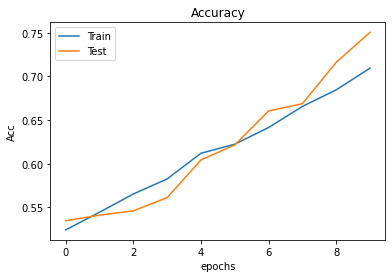

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

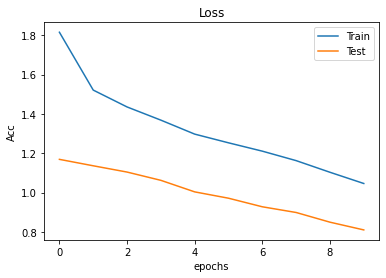

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Model Evaluation

#### a.i)	Print the final train and validation loss and accuracy

In [ ]:
testLoss, testAccuracy = model.evaluate(x_test,y_test)

# Print the final test/validation loss and accuracy.
print('Final testing loss \t', testLoss)
print('Final testing accuracy ', testAccuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.8175 - accuracy: 0.7409
Final testing loss 	 0.8174617886543274
Final testing accuracy  0.7408999800682068


#### a.ii) Plot Confusion Matrix

In [ ]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
y_test_1d=["POSITIVE" if sentiment==1 else "NEGATIVE" for sentiment in y_test]
y_pred_1d = []
y_test_1d = list(y_test_1d)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 0s 85ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

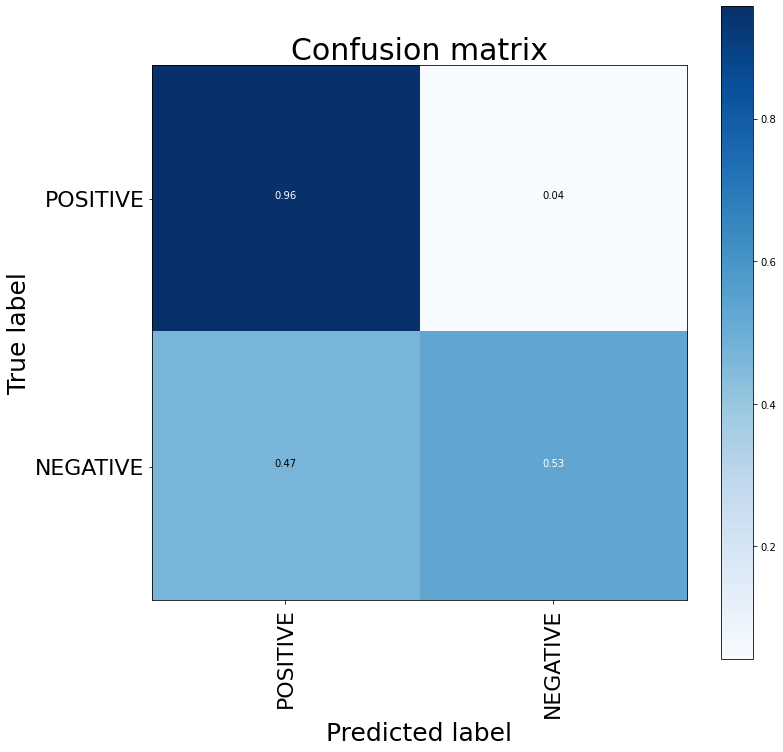

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=['POSITIVE','NEGATIVE'], title="Confusion matrix")
plt.show()

#### a.iii) Print Classification report

In [ ]:
probabilities = model.predict(x_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.4934
 
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      4934
           1       0.00      0.00      0.00      5066

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### a.iv). Write a summary for the best and worst performing class and the overall trend

**NEGATIVE** is the **best** performing class with 67% F1-Scroe and **POSITIVE** is **worst** performing class with 0% F1-Score.

#### b.	Print the two most incorrectly classified texts for each class in the test dataset.

In [ ]:
# show actual and predicted class labels - Overall trend

for i in range(20):
    print ("Actual= {}  Predicted = {}".format(y_test[i], pred[i]))

Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 1  Predicted = 0
Actual= 0  Predicted = 0
Actual= 1  Predicted = 0


**Model Comparison**

3 models trained on same training data.

1.Model with L2 Regularization and Dropouts after layer 1 and batch size=1000.<br>
2.Model with L2 regularization and Dropouts after layer 2 and batch size=500.<br>
3.Model with L2 regularization and Dropouts after layer 3 and batch size=200.

All 3 models have accuracy around 50%.

**Result :** We got more or less same accuracy for all 3 models with difference in run time. For this problem we are seeing more accuracy without L2 regularization.
